<a href="https://colab.research.google.com/github/Kouichi1229/Python_work/blob/main/Visualization_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.filters
import keras
import cv2
from keras import backend as K

# Allow graph embeding in notebook
%matplotlib inline

### 依照使用的模型改圖片的shape

In [ ]:
img = cv2.imread('01.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
res = cv2.resize(img, dsize=(244, 244), interpolation=cv2.INTER_CUBIC) # VGG19 (224,224,3)


# Helper Functions

In [ ]:
def tensor_summary(tensor):
    """Display shape, min, and max values of a tensor."""
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

    
def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)


def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. I can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

# Build Convolutional Network <= 這裡要改成自己 pre-train Model
### 1. VGG19

In [ ]:
import tensorflow.keras.applications.vgg19 as vgg19

In [ ]:
model1 = vgg19.VGG19(weights='imagenet')
model1.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Load pre_trained model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
Model_path = 'VGG19_BUG.h5'
modle1 = load_model(Model_path) # <= OSError : 訓練出來的權重下載沒有完全
modle1.summary

OSError: ignored

# Test the Model on Random Images

shape: (244, 244, 3)  min: 0  max: 255


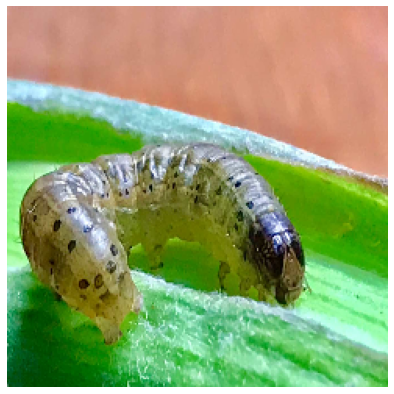

In [ ]:
res.shape == (224,224,3)
tensor_summary(res)
display_images([res],cols=2)

In [ ]:
x = res.astype(np.float32)
x = x[np.newaxis,...]
x = vgg19.preprocess_input(x)

In [ ]:
# classify the image
prediction = model1.predict(x)
print(prediction[0][:10])

[6.1857257e-08 2.8501051e-07 9.9291810e-09 7.8978486e-09 1.9452735e-09
 1.1271561e-07 4.0336516e-08 1.1737611e-08 8.3984331e-09 2.0953797e-07]


### 這裡是原本 keras api modle 原本文件有的種類分類(label index)

In [ ]:
label_index = np.argmax(prediction)
print("label index: ",label_index)

vgg19.decode_predictions(prediction)

label index:  79
40960/35363 [==================================] - 0s 0us/step


[[('n01784675', 'centipede', 0.74438095),
  ('n01990800', 'isopod', 0.10201321),
  ('n02259212', 'leafhopper', 0.07917054),
  ('n01945685', 'slug', 0.012978656),
  ('n02206856', 'bee', 0.010221104)]]

#### ---------- imagenet_classes 沒有用到



```
-秋行軍蟲Spodoptera frugiperda：https://reurl.cc/k0bAYG
-斜紋夜盜Spodoptera litura : https://reurl.cc/2gGoEm
-番茄夜蛾Helicoverpa armigera：https://reurl.cc/WLZ7p9
-甜菜夜蛾 Spodoptera exigua : https://reurl.cc/k0Y7nG
###ALL datasets:  https://reurl.cc/Oq3AdD
```



In [ ]:
imagenet_classes =['Spodoptera frugiperda','Spodoptera litura','Helicoverpa armigera','Spodoptera exigua']



# Heatmap


In [ ]:
step = 56
heatmap_x =[]
for row in range(0, res.shape[0],step):
  for col in range(0,res.shape[1],step):
    new_Image = res.copy()
    new_Image[row:row+step,col:col+step, :] = [250,128,128]
    heatmap_x.append(new_Image)
heatmap_x = np.stack(heatmap_x)
heatmap_x.shape

(25, 244, 244, 3)

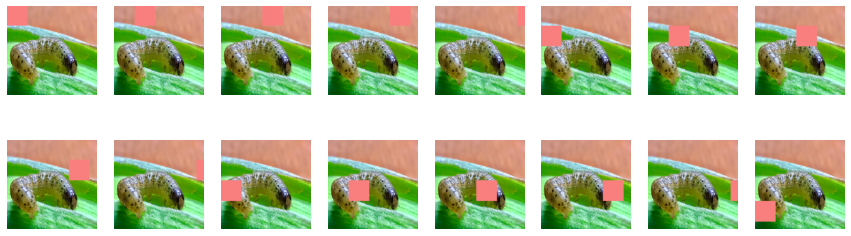

In [ ]:
display_images(heatmap_x[:16],cols=8)

In [ ]:
heatmap_y = model1.predict(vgg19.preprocess_input(heatmap_x.astype(np.float32)))
tensor_summary(heatmap_y )

shape: (25, 1000)  min: 3.2055114118634265e-09  max: 0.5922848582267761


In [ ]:
probs = heatmap_y[:,label_index]
tensor_summary(probs)

shape: (25,)  min: 0.00014928159362170845  max: 0.044689614325761795


In [ ]:
heatmap = (probs.max()-probs)/(probs.max()-probs.min())
heatmap = np.reshape(heatmap,(5,5))
tensor_summary(heatmap)

shape: (5, 5)  min: 0.0  max: 1.0


shape: (5, 5)  min: 0.0  max: 1.0


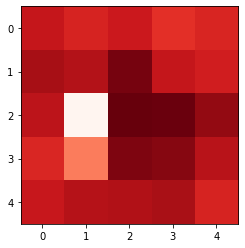

In [ ]:
tensor_summary(heatmap)
_ = plt.imshow(heatmap,cmap=plt.cm.Reds)

shape: (244, 244, 3)  min: 0.0  max: 249.20216369628906


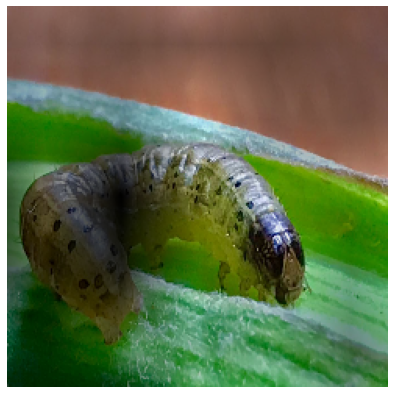

In [ ]:
def apply_mask(image,mask):
  mask = skimage.transform.resize(normalize(mask), image.shape[:2])[:,:,np.newaxis].copy()
  image_heatmap = image*mask
  tensor_summary(image_heatmap)
  display_images([image_heatmap],cols=2)

apply_mask(res,heatmap**2)

# Visualize the Weights (不是那麼重要 可不用跑)



In [ ]:
weights = model1.get_layer('block1_conv1').get_weights()[0]
weights.shape, weights.min(), weights.max()

NameError: ignored

In [ ]:
display_images([weights[:,:,::-1,i] for i in range(64)], cols=16, interpolation='none')

NameError: ignored

# Visualize Activations

In [ ]:
def read_layer(model, x, layer_name):
    """Return the activation values for the specifid layer"""
    # Create Keras function to read the output of a specific layer
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

##### 看模組的層 對照名稱(Layer)
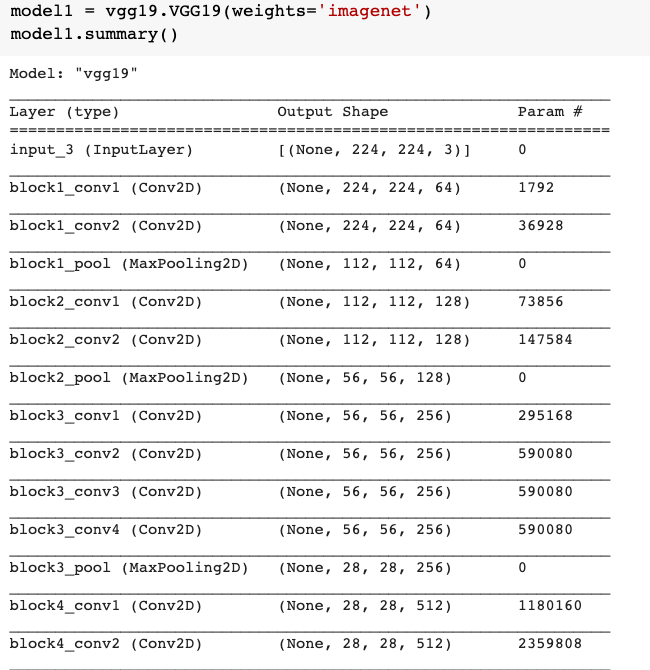

shape: (1, 244, 244, 64)  min: 0.0  max: 614.7448120117188


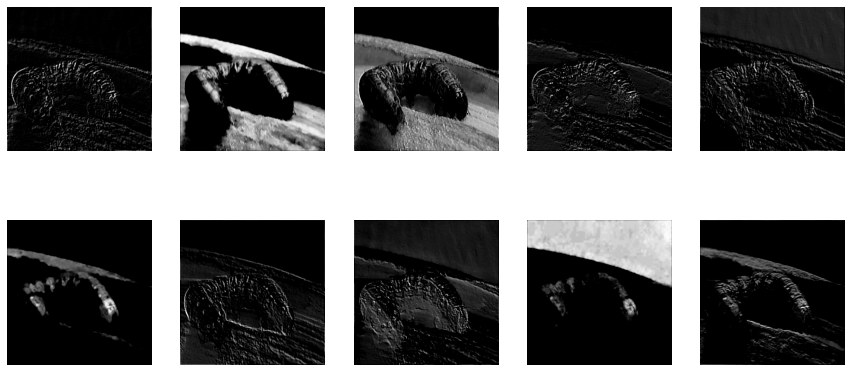

In [ ]:
#                      改這裡的名稱就能看其他層
# -------------------------v
view_layer(model1, x, "block1_conv1")

shape: (1, 244, 244, 64)  min: 0.0  max: 1953.3594970703125


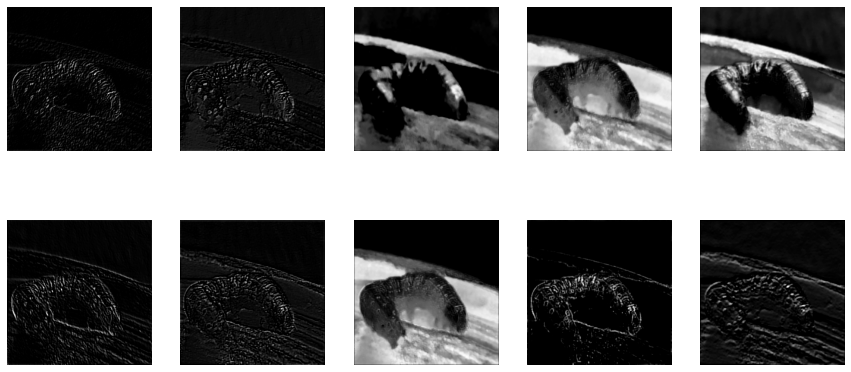

In [ ]:
view_layer(model1, x, "block1_conv2")

shape: (1, 122, 122, 128)  min: 0.0  max: 3500.12646484375


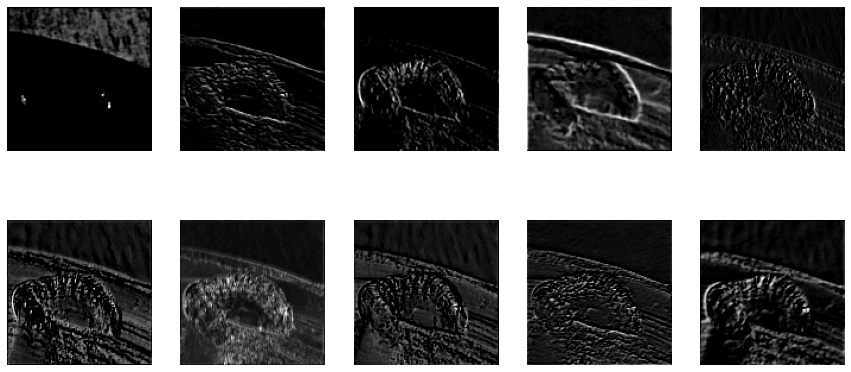

In [ ]:
view_layer(model1, x, "block2_conv1")

shape: (1, 122, 122, 128)  min: 0.0  max: 4956.0810546875


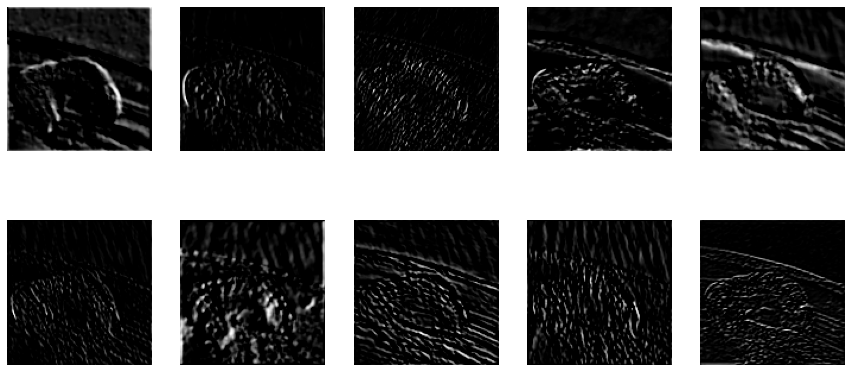

In [ ]:
view_layer(model1, x, "block2_conv2")

shape: (1, 61, 61, 256)  min: 0.0  max: 14112.0986328125


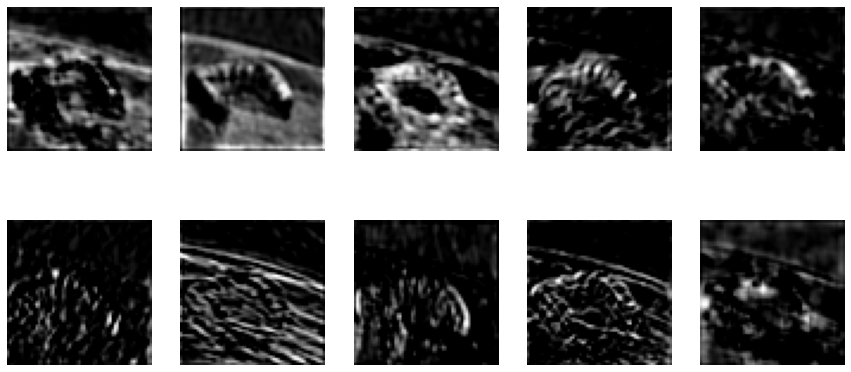

In [ ]:
view_layer(model1, x, "block3_conv4")

shape: (1, 30, 30, 512)  min: 0.0  max: 5444.658203125


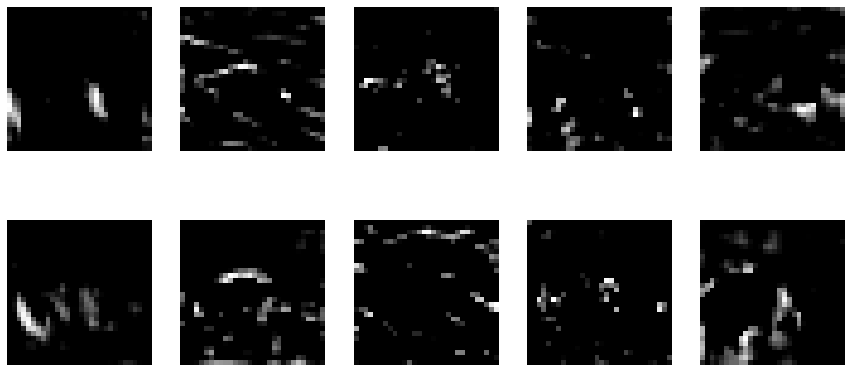

In [ ]:
view_layer(model1, x, "block4_conv4")

shape: (1, 15, 15, 512)  min: 0.0  max: 3314.403076171875


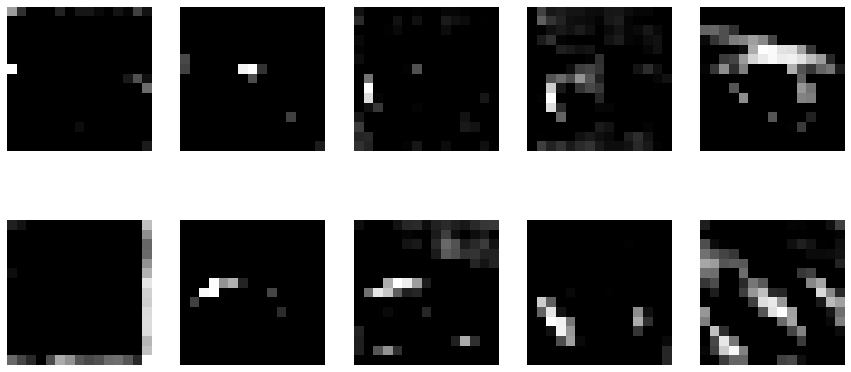

In [ ]:
view_layer(model1, x, "block5_conv1")

shape: (1, 15, 15, 512)  min: 0.0  max: 555.8921508789062


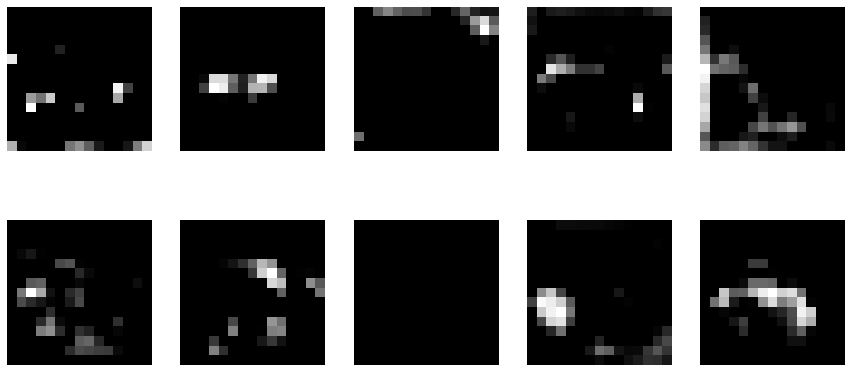

In [ ]:
view_layer(model1, x, "block5_conv3")

shape: (1, 15, 15, 512)  min: 0.0  max: 555.8921508789062
shape: (244, 244, 3)  min: 0.0  max: 143.55245971679688


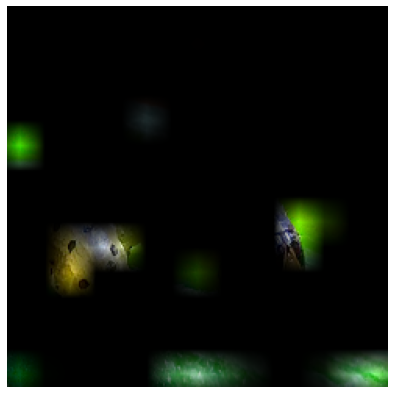

In [ ]:
#                      改這裡的名稱就能看其他層
# -------------------------v
a = read_layer(model1, x, "block5_conv3")
apply_mask(res, a[:,:, 0]) # 遮罩

shape: (1, 15, 15, 512)  min: 0.0  max: 212.43838500976562
shape: (244, 244, 3)  min: 0.0  max: 220.06016540527344


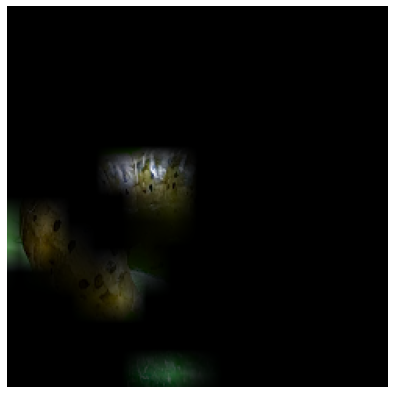

In [ ]:
a = read_layer(model1, x, "block5_conv4")
apply_mask(res, a[:,:, 0])

shape: (1, 1000)  min: 5.500662078605778e-11  max: 0.7443809509277344


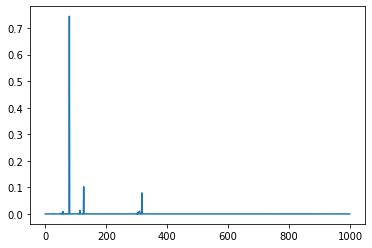

In [ ]:
a = read_layer(model1,x,'predictions')
_= plt.plot(a)